#  **Malaria Cell Classification using CNN And Transfer Learning**

## **PROJECT TEAM ID: PTID-AI-MAY-23-1307**
## **PROJECT ID: PRAICP-1013- MALARIA CELL CLASSIFICATION**

## 1. **Domain analysis**

1. **Introduction**
* Malaria Overview: Malaria is a
life-threatening disease caused by Plasmodium parasites, transmitted to humans through the bites of infected female Anopheles mosquitoes.

* Diagnosis: Traditional diagnosis methods include microscopic examination of blood smears, where experts identify and classify infected red blood cells (RBCs). This method is time-consuming, requires skilled technicians, and is prone to human error.

2. **Machine Learning and Image Analysis in Healthcare**
* Role of ML in Healthcare: Machine learning (ML), particularly deep learning, has revolutionized medical diagnostics by providing tools for automated, accurate, and fast analysis of medical images.

* Image Analysis: Convolutional Neural Networks (CNNs) are a class of deep learning models highly effective in image recognition and classification tasks. They are used to analyze medical images to detect and classify diseases, including malaria.

3. **CNN Architecture**:
* Basic CNN Structure: A CNN typically consists of several layers, including convolutional layers, pooling layers, and fully connected layers. These layers work together to automatically learn and extract features from input images.

* Customization for Malaria: For malaria cell classification, a CNN can be trained to distinguish between parasitized and uninfected RBCs using labeled images of blood smears.

4. **Transfer Learning**
* Concept: Transfer learning involves using a pre-trained model on a large dataset and fine-tuning it on a smaller, specific dataset. This approach is beneficial when the available labeled data is limited.

* Pre-trained Models: Models like VGG, ResNet, and Inception, pre-trained on large datasets like ImageNet, can be adapted for malaria cell classification by fine-tuning their weights on a malaria-specific dataset.


## **2. Data Collection and Preprocessing**

* Download the dataset:<a href="https://d3ilbtxij3aepc.cloudfront.net/projects/CNN-PROJECT-7-11/Malaria-2.zip"> Malaria cell classification dataset</a>

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import and Unzip the file
import zipfile
import os

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/My Drive/cell_images.zip'

# Directory where you want to extract the contents
cell_images = '/content/extracted_folder'

# Create the directory if it doesn't exist
os.makedirs(cell_images, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(cell_images)


In [3]:
# Import the libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import PIL
import matplotlib.pyplot as plt

In [4]:
! pip install split-folders

In [5]:
import splitfolders
splitfolders.ratio("/content/extracted_folder/cell_images/",output='subset',ratio=(0.8,0.1,0.1),seed=1337)


Copying files: 27560 files [00:06, 3996.05 files/s]


In [6]:
# Resize all the images and create the train, val, test batches of images
image_size = [224, 224]

train_path = '/content/subset/train'
valid_path = '/content/subset/val'
test_path = '/content/subset/test'


In [7]:
# Get the number of output classes
folders = glob('/content/subset/train/*')

In [8]:
folders

['/content/subset/train/Uninfected', '/content/subset/train/Parasitized']

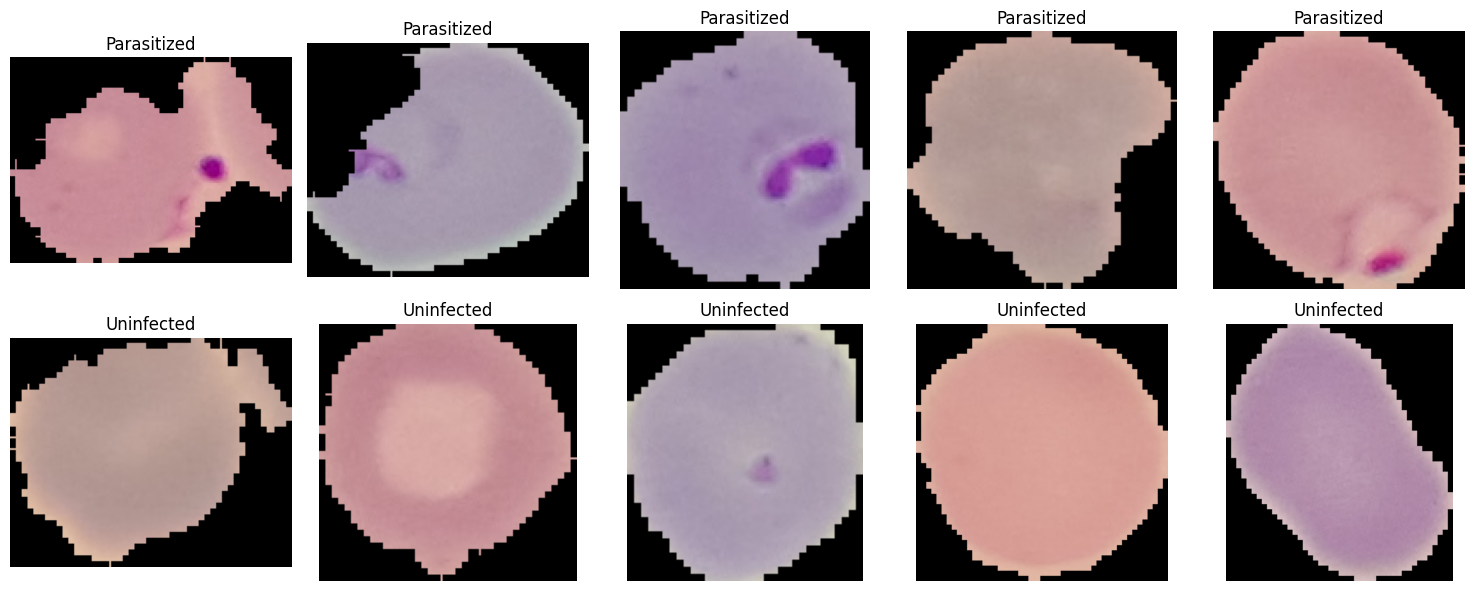

In [9]:
from PIL import Image

# Define the path to the dataset directories
parasitized_dir = '/content/subset/train/Parasitized'
uninfected_dir = '/content/subset/train/Uninfected'

# Function to load images from a directory
def load_images_from_folder(folders, max_images=10):
    images = []
    for filename in os.listdir(folders):
        img_path = os.path.join(folders, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            images.append(img)
        if len(images) >= max_images:
            break
    return images

# Load a sample of images from both directories
num_images = 5  # number of images to display from each category
parasitized_images = load_images_from_folder(parasitized_dir, num_images)
uninfected_images = load_images_from_folder(uninfected_dir, num_images)

# Combine the images into a single list for display
all_images = parasitized_images + uninfected_images
labels = ['Parasitized'] * len(parasitized_images) + ['Uninfected'] * len(uninfected_images)

# Display the images in a grid
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

for i in range(num_images):
    axes[0, i].imshow(parasitized_images[i])
    axes[0, i].set_title("Parasitized")
    axes[0, i].axis('off')

    axes[1, i].imshow(uninfected_images[i])
    axes[1, i].set_title("Uninfected")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


## 3. Model Selection and preperation


*   Choose the model
*   Modify and bulid the architecture



In [10]:
# Import the Vgg19 library
vgg19 = VGG19(input_shape=image_size + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 5s 0us/step


In [11]:
# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [12]:
# Adding layers - you can add more if you want
x = Flatten()(vgg19.output)

In [13]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

In [14]:
# view the shape and trainable parameters of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Create Model from scratch using CNN
from tensorflow.keras.layers import MaxPooling2D

model=Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 64)        0

## 4. Model compilation

In [16]:
# Cost function and optimization method
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [17]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = (1./255),
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen= ImageDataGenerator(rescale=(1./255))

test_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
# Provide the same target size as initialied for the image size
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical')

Found 22046 images belonging to 2 classes.


In [19]:
val_set = test_datagen.flow_from_directory(valid_path,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          class_mode = 'categorical')

Found 2756 images belonging to 2 classes.


In [20]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2756 images belonging to 2 classes.


In [21]:
# Check the size of train, validation, test sets
print(f"Train set batch shape: {train_set[0][0].shape}")
print(f"Validation set batch shape: {val_set[0][0].shape}")
print(f"Test set batch shape: {test_set[0][0].shape}")



Train set batch shape: (32, 224, 224, 3)
Validation set batch shape: (32, 224, 224, 3)
Test set batch shape: (32, 224, 224, 3)


## 5. Train Model

In [22]:
# fit the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint('model_vgg19.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
train_model = model.fit(
    train_set,
    validation_data=val_set,
    epochs=50,
    steps_per_epoch=len(train_set),
    validation_steps=len(val_set),
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
689/689 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.7993

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


689/689 [==============================] - 317s 453ms/step - loss: 0.4718 - accuracy: 0.7993 - val_loss: 0.2781 - val_accuracy: 0.9115
Epoch 2/50
689/689 [==============================] - 313s 454ms/step - loss: 0.2660 - accuracy: 0.9106 - val_loss: 0.1669 - val_accuracy: 0.9423
Epoch 3/50
689/689 [==============================] - 315s 457ms/step - loss: 0.2598 - accuracy: 0.9130 - val_loss: 0.1854 - val_accuracy: 0.9394
Epoch 4/50
689/689 [==============================] - 310s 450ms/step - loss: 0.2433 - accuracy: 0.9187 - val_loss: 0.1674 - val_accuracy: 0.9438
Epoch 5/50
689/689 [==============================] - 306s 444ms/step - loss: 0.2384 - accuracy: 0.9184 - val_loss: 0.1666 - val_accuracy: 0.9481
Epoch 6/50
689/689 [==============================] - 298s 433ms/step - loss: 0.2323 - accuracy: 0.9218 - val_loss: 0.1539 - val_accuracy: 0.9499
Epoch 7/50
689/689 [==============================] - 298s 433ms/step - loss: 0.2248 - accuracy: 0.9239 - val_loss: 0.1534 - val_accura

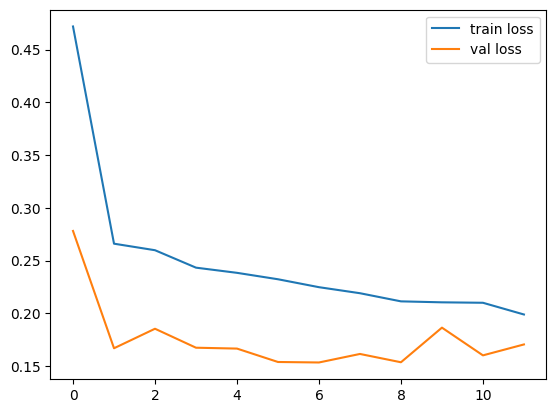

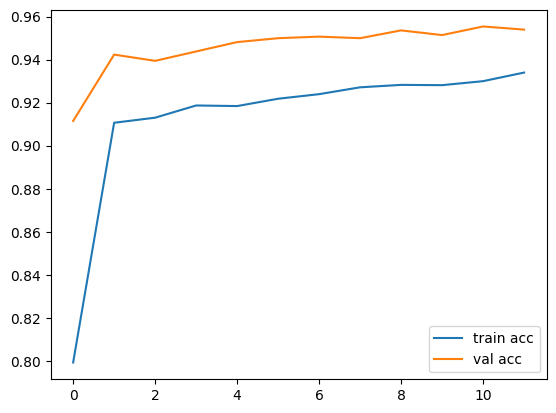

<Figure size 640x480 with 0 Axes>

In [25]:
# plot the  validation loss
plt.plot(train_model.history['loss'], label='train loss')
plt.plot(train_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('Validation_loss')

# plot the accuracy
plt.plot(train_model.history['accuracy'], label='train acc')
plt.plot(train_model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Validation_accuracy')

## 6.Model Evaluation 

In [ ]:
train_result= model.evaluate(train_set)
print("train accuracy and loss", train_result)

test_result= model.evaluate(test_set)
print("Test accuracy and loss", test_result)

477/689 [===================>..........] - ETA: 1:25 - loss: 0.2203 - accuracy: 0.9274

In [ ]:
# Create a dataframe to display the loss and accuracy of the validation and train data obtained result.
data = pd.DataFrame(zip (train_result, val_result), coulums=['Train','Validation'], index= ['Loss','Accuracy'])

In [ ]:
# save it as a h5 file

model.save('model_vgg19.h5')

## 7. Model Prediction on test dataset

In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred

array([[9.99876857e-01, 1.23175341e-04],
       [9.99977112e-01, 2.29190919e-05],
       [7.58346558e-01, 2.41653457e-01],
       [9.99925494e-01, 7.45595753e-05],
       [9.90784764e-01, 9.21520963e-03],
       [9.12076458e-02, 9.08792377e-01],
       [2.70295113e-01, 7.29704857e-01],
       [3.21944878e-02, 9.67805505e-01],
       [9.62613881e-01, 3.73861678e-02],
       [5.13265312e-01, 4.86734688e-01],
       [9.87143576e-01, 1.28563549e-02],
       [9.97780263e-01, 2.21971911e-03],
       [9.32238042e-01, 6.77619576e-02],
       [9.21115577e-01, 7.88843632e-02],
       [3.17853913e-02, 9.68214571e-01],
       [1.00000000e+00, 9.47071488e-09],
       [2.65438944e-01, 7.34561086e-01],
       [9.99419808e-01, 5.80202264e-04],
       [9.40651655e-01, 5.93483634e-02],
       [9.85742450e-01, 1.42575456e-02],
       [9.99954581e-01, 4.54339461e-05],
       [9.99656916e-01, 3.43117106e-04],
       [5.88945560e-02, 9.41105425e-01],
       [9.99902725e-01, 9.72729686e-05],
       [7.317669

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1], dtype=int64)

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
model=load_model('model_vgg19.h5')

## 8. Test the images

In [ ]:
# import the library and load the path of the img in test data
from tensorflow.keras.preprocessing import image
img=image.load_img('/content/subset/test/2.png',target_size=(224,224))

In [ ]:
# Convert the image into array
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
# shape of the data
x.shape

(224, 224, 3)

In [ ]:
# Scale the data
x=x/255

In [ ]:
# Expand the dimension of img
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
# Prediction
model.predict(img_data)

array([[0.01155142, 0.98844856]], dtype=float32)

## 9. Final prediction

In [ ]:
# Final prediction
a=np.argmax(model.predict(img_data), axis=1)
print('Final Prediction: ',a)

if(a==1):
    print("Uninfected")
else:
    print("Parasitized")

Uninfected


## 10. Visualization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming imgs and labels are obtained from the test set
imgs, labels = next(test_set)

# Create a figure with specified size
fig = plt.figure(figsize=(15, 15))

# Define the number of rows and columns
columns = 3
rows = 3

# Define class names for predictions
class_names = ['Parasitized', 'Uninfected']

# Loop through the number of images to be displayed
for i in range(columns * rows):
    # Add a subplot for each image
    ax = fig.add_subplot(rows, columns, i + 1)

    # Preprocess the image for prediction
    img_t = np.expand_dims(imgs[i], axis=0)

    # Predict the class of the image
    prediction = model.predict(img_t)

    # Get the index of the highest probability class
    idx = np.argmax(prediction[0])

    # Get the true label
    true_label = class_names[int(labels[i][0])]

    # Set the title with predicted class, probability, and true label
    ax.set_title(f"Pred: {class_names[idx]} ({prediction[0][idx]:.2f})\nTrue: {true_label}",
                 color='red' if class_names[idx] != true_label else 'green',
                 fontsize=12)

    # Remove axis ticks for clarity
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the image
    ax.imshow(imgs[i])

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()
